In [1]:
import numpy as np

import pandas as pd
from collections import defaultdict
import string

import sklearn
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold

import xgboost as xgb
import matplotlib.pyplot as plt

from utils import preprocess


Using TensorFlow backend.


In [2]:
def delete_unrelated_feilds(df):
    fields = set(df.keys())
    for k in fields:
        if 'Unnamed' in k:
            df.drop(k, axis=1, inplace=True)
    return df

df = pd.read_csv('./data/train_feature.csv')
df_test = pd.read_csv('./data/test_feature.csv')

df = delete_unrelated_feilds(df)
df_test = delete_unrelated_feilds(df_test)

df.to_csv('./data/train_feature.csv')
df_test.to_csv('./data/test_feature.csv')

In [3]:
df = pd.read_csv('./data/train_feature.csv')
df_test = pd.read_csv('./data/test_feature.csv')
text = df.text.values
text_test = df_test.text.values

author2class = {'EAP': 0, 'HPL' : 1, 'MWS' : 2}
class2author = ['EAP', 'HPL', 'MWS']
y = np.array([author2class[a] for a in df.author])

In [4]:
df.drop('id', axis=1, inplace=True)
df.drop('text', axis=1, inplace=True)
df.drop('author', axis=1, inplace=True)

df_test.drop('id', axis=1, inplace=True)
df_test.drop('text', axis=1, inplace=True)
df = delete_unrelated_feilds(df)
df_test = delete_unrelated_feilds(df_test)


In [12]:
# for t in [df, df_test]:
#     for a in class2author:
#         t.drop('{}_fasttext_cbow_wide_logi'.format(a), axis=1, inplace=True)
#         t.drop('{}_fasttext_bigram_reverse'.format(a), axis=1, inplace=True)
# #         t.drop('{}_lstm'.format(a), axis=1, inplace=True)
# #         t.drop('{}_word2vec_google_logi'.format(a), axis=1, inplace=True)    

# #     df_test.drop('{}_fasttext_bigram_reverse'.format(a), axis=1, inplace=True)        
# #     df.drop('{}_fasttext_skip_low_dim_logi'.format(a), axis=1, inplace=True)
# #     df_test.drop('{}_fasttext_skip_low_dim_logi'.format(a), axis=1, inplace=True)        
# #     df.drop('{}_char_wb_count_NB'.format(a), axis=1, inplace=True)
# #     df_test.drop('{}_char_wb_count_NB'.format(a), axis=1, inplace=True)
# # df.drop('num_words'.format(a), axis=1, inplace=True)
#     # df_test.drop('num_words'.format(a), axis=1, inplace=True)                
# #     t.drop('rate_uniq_chars', axis=1, inplace=True)
# #     t.drop('HPL_char_wb_count_NB', axis=1, inplace=True)
# #     t.drop('num_words', axis=1, inplace=True)


In [13]:
ite = 5
losses = []
num_split = 5
results = np.zeros((len(df_test), 3))


np.random.seed(1234)
param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.11 #01
param['max_depth'] = 2
param['silent'] = 1
param['num_class'] = 3
param['eval_metric'] = 'mlogloss'
param['min_child_weight'] = 1
param['subsample'] = 0.8
param['colsample_bytree'] = 0.3 # 0.3
param['seed'] = 7
num_rounds = 6000

kf = KFold(n_splits=num_split, shuffle=True, random_state=2017)

for train_ids, val_ids in kf.split(df):
    x_train, x_val = df.loc[train_ids], df.loc[val_ids]
    y_train, y_val = y[train_ids], y[val_ids]

    plst = list(param.items())
    xgtrain = xgb.DMatrix(x_train, label=y_train)
    xgtest = xgb.DMatrix(x_val, label=y_val)

    watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
    model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=170, verbose_eval=100)

    l = log_loss(y_true=y_val, y_pred=model.predict(xgtest, ntree_limit=model.best_ntree_limit))
    losses.append(l)

    xgtest2 = xgb.DMatrix(df_test)
    results += model.predict(xgtest2, ntree_limit=model.best_ntree_limit)


[0]	train-mlogloss:0.993001	test-mlogloss:0.993093
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 170 rounds.
[100]	train-mlogloss:0.252526	test-mlogloss:0.267105
[200]	train-mlogloss:0.229215	test-mlogloss:0.261234
[300]	train-mlogloss:0.213606	test-mlogloss:0.260226
[400]	train-mlogloss:0.201188	test-mlogloss:0.258981
[500]	train-mlogloss:0.190164	test-mlogloss:0.259931
Stopping. Best iteration:
[401]	train-mlogloss:0.201094	test-mlogloss:0.258869

[0]	train-mlogloss:0.992559	test-mlogloss:0.993945
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 170 rounds.
[100]	train-mlogloss:0.251391	test-mlogloss:0.276051
[200]	train-mlogloss:0.228233	test-mlogloss:0.268491
[300]	train-mlogloss:0.212635	test-mlogloss:0.267725
[400]	train-mlogloss:0.199426	test-mlogloss:0.267774
[500]	train-mlogloss:0.187966	test-ml

In [14]:
losses, np.mean(losses)

([0.25886888152880239,
  0.26750020210728248,
  0.27894317177102324,
  0.24854071683492329,
  0.25527238877962627],
 0.26182507220433149)

In [7]:
losses, np.mean(losses) # best

([0.25850233691032937,
  0.26999177473710539,
  0.27681713880432079,
  0.2521633001711317,
  0.25445806337103483],
 0.26238652279878438)

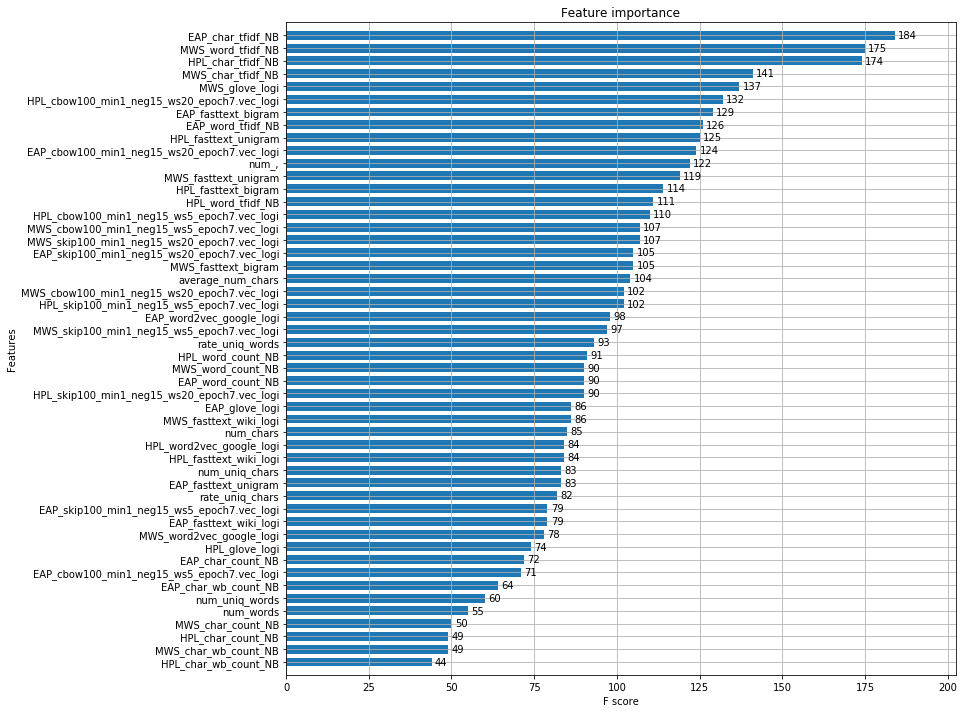

In [15]:
fig, ax = plt.subplots(figsize=(12, 12))
xgb.plot_importance(model, max_num_features=100, height=0.7, ax=ax)
plt.show()

In [16]:
submission_df = pd.read_csv('./data/sample_submission.csv')
for a, i in author2class.items():
    submission_df[a] = results[:, i]/num_split/5

with open('./results/results.csv', 'w') as f:
    f.write('"id","EAP","HPL","MWS"\n')
    for (index, row) in submission_df.iterrows():
        f.write(','.join(['\"' + row['id'] + '\"'] +  list(map(str, [row['EAP'], row['HPL'], row['MWS']]))) + '\n')